In [2]:
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import sys


from gensim.scripts.glove2word2vec import glove2word2vec
from keras.utils import plot_model 


#from keras import callbacks
from keras import optimizers
from keras import models # simplify the following lines...


from keras.models import Sequential, Model, load_model
from keras.layers import Attention, Conv1D, MaxPooling1D, Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical



from nltk.corpus import stopwords




import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints


[nltk_data] Downloading package stopwords to /Users/karen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load data

In [5]:
train_body = pd.read_csv('data/train_bodies.csv')
train_stances = pd.read_csv('data/train_stances.csv')
test_body = pd.read_csv('data/competition_test_bodies.csv')
test_stances =pd.read_csv('data/competition_test_stances.csv')

In [6]:
train_body.head(5)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [7]:
train_stances.head(5)

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [8]:
test_body.head(5)

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [9]:
test_stances.head(5)

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [10]:
train_set = train_stances.merge(train_body, how = 'left', on = 'Body ID')
test_set = test_stances.merge(test_body,how = 'left', on = 'Body ID')

In [11]:
train_set.head(5)


,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [12]:
test_set.head(5)

,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated,Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated,An airline passenger headed to Dallas was remo...


In [13]:
train_set['text'] = train_set[['Headline', 'articleBody']].apply(lambda x: ' '.join(x), axis=1)
train_set=train_set[['Body ID','Stance','text']]

test_set['text'] = test_set[['Headline', 'articleBody']].apply(lambda x: ' '.join(x), axis=1)
test_set=test_set[['Body ID','Stance','text']]

In [14]:
train_set.head(5)

,Body ID,Stance,text
0,712,unrelated,Police find mass graves with at least '15 bodi...
1,158,agree,Hundreds of Palestinians flee floods in Gaza a...
2,137,unrelated,"Christian Bale passes on role of Steve Jobs, a..."
3,1034,unrelated,HBO and Apple in Talks for $15/Month Apple TV ...
4,1923,disagree,Spider burrowed through tourist's stomach and ...


In [15]:
test_set.head(5)

,Body ID,Stance,text
0,2008,unrelated,Ferguson riots: Pregnant woman loses eye after...
1,1550,unrelated,Crazy Conservatives Are Sure a Gitmo Detainee ...
2,2,unrelated,A Russian Guy Says His Justin Bieber Ringtone ...
3,1793,unrelated,"Zombie Cat: Buried Kitty Believed Dead, Meows ..."
4,37,unrelated,Argentina's President Adopts Boy to End Werewo...


In [16]:
LABELS = {'agree':1,'disagree':2,'discuss':3,'unrelated':0}
y = train_set['Stance']
y_train = []
for item in y:
    y_train.append(LABELS[item])
    
y = test_set['Stance']
y_test = []
for item in y:
	y_test.append(LABELS[item])

In [17]:
x_train = train_set['text']
x_test = test_set['text']

In [18]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["aren't", "not", "no","don't","isn't","doesn't"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

In [19]:
x_train = x_train.apply(remove_stopwords)
x_test = x_test.apply(remove_stopwords)

In [20]:
MAX_X_TRAIN_10 = int(np.percentile([len(doc) for doc in x_train], 10))
MAX_X_TRAIN_50 = int(np.percentile([len(doc) for doc in x_train], 50))
MAX_X_TRAIN_90 = int(np.percentile([len(doc) for doc in x_train], 90))
print('10th Percentile Length:', MAX_X_TRAIN_10)
print('50th Percentile Length:', MAX_X_TRAIN_50)
print('90th Percentile Length:', MAX_X_TRAIN_90)

10th Percentile Length: 596
50th Percentile Length: 1437
90th Percentile Length: 3179


In [21]:
tk = Tokenizer(num_words= 40000,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(x_train)
#convert the text to a list of integer indexes
x_train_seq = tk.texts_to_sequences(x_train)
x_test_seq = tk.texts_to_sequences(x_test)

max_length = 1000
x_train = pad_sequences(x_train_seq, maxlen=max_length, padding='post') 
x_test = pad_sequences(x_test_seq, maxlen=max_length, padding='post')


le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)


# Build embedding matrix

In [22]:
glove_input_file = 'data/glove.twitter.27B.50d.txt'
word2vec_output_file = 'data/glove.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [23]:
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tk.word_index)+1, 50)) # +1 is because the matrix indices start with 0
for word, i in tk.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
        #none: if words in sentence don't have pre-trained corresponding embedding, then error occurs

    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        #if pre-trained word embedding exists，then let embeddings_matrix[i] is this embedding
        #Wi:the ith row of embeddings_matrix

del embeddings

# Model_1

In [22]:
model_1 = Sequential()
model_1.add(Embedding(input_dim=len(tk.word_index)+1,
                          output_dim=50,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer', #False
                          mask_zero=True))
#mask_zero is to deal with padding problem
#model.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer1'))) #bi(lstm)
model_1.add(Bidirectional(LSTM(100, return_sequences=False, name='Bidrectional_lstm_layer1')))
#model_1.add(BatchNormalization())
model_1.add(Dropout(rate=0.6, name='dropout_1')) 
model_1.add(Dense(4, activation='softmax', name='output_layer'))

In [23]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1392700   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               120800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 804       
Total params: 1,514,304
Trainable params: 1,514,304
Non-trainable params: 0
_________________________________________________________________


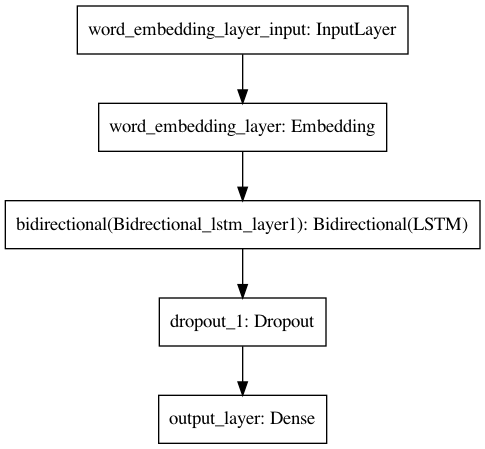

In [24]:
plot_model(model_1, to_file='model_1.png',show_shapes=False)

In [25]:
def bilstm_model(model_1):
    model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    history_1 = model_1.fit(x_train, y_train_oh,
          batch_size=128,
          epochs=6,
         validation_split = 0.2)

    return history_1

In [26]:
history_1 = bilstm_model(model_1)

Epoch 1/6
313/313 [==============================] - 2377s 8s/step - loss: 0.7175 - accuracy: 0.7477 - val_loss: 0.5379 - val_accuracy: 0.8063
Epoch 2/6
313/313 [==============================] - 2228s 7s/step - loss: 0.4841 - accuracy: 0.8228 - val_loss: 0.4113 - val_accuracy: 0.8432
Epoch 3/6
313/313 [==============================] - 2299s 7s/step - loss: 0.3685 - accuracy: 0.8617 - val_loss: 0.3284 - val_accuracy: 0.8739
Epoch 4/6
313/313 [==============================] - 5640s 18s/step - loss: 0.2926 - accuracy: 0.8907 - val_loss: 0.2881 - val_accuracy: 0.8905
Epoch 5/6
313/313 [==============================] - 3294s 11s/step - loss: 0.2346 - accuracy: 0.9097 - val_loss: 0.2423 - val_accuracy: 0.9108
Epoch 6/6
313/313 [==============================] - 2952s 9s/step - loss: 0.1910 - accuracy: 0.9267 - val_loss: 0.2181 - val_accuracy: 0.9193


In [54]:
preds_1 = model_1.predict(x_test)

In [59]:
outputs_1 = [np.argmax(p) for p in preds_1]
test_stances = pd.read_csv('data/competition_test_stances_unlabeled.csv')
    
for i in range(len(outputs_1)):
    if outputs_1[i] == 0: outputs_1[i] = "unrelated"
    if outputs_1[i] == 1: outputs_1[i] = "disagree"
    if outputs_1[i] == 2: outputs_1[i] = "agree"
    if outputs_1[i] == 3: outputs_1[i] = "discuss"

df_predicted1 = {}
df_predicted1 = pd.DataFrame({'Stance': outputs_1})
result1 = pd.concat([test_stances, df_predicted1], axis=1, sort=False)
result1.to_csv('data/model_1_preds_woutSW.csv', index=False, encoding='utf-8')

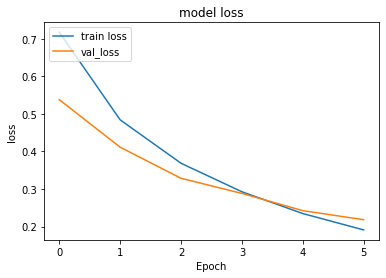

In [28]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'val_loss'], loc='upper left')
plt.show()

In [17]:
scoress = model_1.evaluate(x_test, y_test_oh)
print("%s: %.2f%%"%(model_1.metrics_names[1], scoress[1]*100))

795/795 [==============================] - 129s 162ms/step - loss: 0.9345 - accuracy: 0.6724
accuracy: 67.24%


# Model_2

In [84]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(tk.word_index)+1,input_length = 1500,
                              output_dim=50,
                              weights = [embeddings_matrix], trainable= True, name='word_embedding_layer', 
                              mask_zero=True)) # trainable=True results in overfitting

model_2.add(Dropout(0.6))
model_2.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_2.add(BatchNormalization())
#model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(4, activation='softmax', name='output_layer'))   

In [85]:
def cnn_model(model_2):
    model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    history_2 = model_2.fit(x_train, y_train_oh,
          batch_size=128,
          epochs=6,
         validation_split = 0.2)

    return history_2

In [86]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 1500, 50)          1392700   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1500, 50)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1500, 32)          8032      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 750, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 750, 64)           6208      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 375, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)              

In [87]:
history_2 = cnn_model(model_2)

Epoch 1/6
313/313 [==============================] - 501s 2s/step - loss: 0.8568 - accuracy: 0.7210 - val_loss: 0.7990 - val_accuracy: 0.7330
Epoch 2/6
313/313 [==============================] - 481s 2s/step - loss: 0.8022 - accuracy: 0.7312 - val_loss: 0.7983 - val_accuracy: 0.7330
Epoch 3/6
313/313 [==============================] - 492s 2s/step - loss: 0.7997 - accuracy: 0.7313 - val_loss: 0.8018 - val_accuracy: 0.7330
Epoch 4/6
313/313 [==============================] - 509s 2s/step - loss: 0.8001 - accuracy: 0.7312 - val_loss: 0.7932 - val_accuracy: 0.7330
Epoch 5/6
313/313 [==============================] - 463s 1s/step - loss: 0.7997 - accuracy: 0.7313 - val_loss: 0.7924 - val_accuracy: 0.7330
Epoch 6/6
313/313 [==============================] - 421s 1s/step - loss: 0.7998 - accuracy: 0.7313 - val_loss: 0.7919 - val_accuracy: 0.7332


In [88]:
model_2.save('model_2_withoutSW') 

INFO:tensorflow:Assets written to: model_2_withoutSW/assets


In [89]:
preds = model_2.predict(x_test)

In [39]:
scoress = model_2.evaluate(x_test, y_test_oh)
print("%s: %.2f%%"%(model_2.metrics_names[1], scoress[1]*100))

795/795 [==============================] - 97s 122ms/step - loss: 0.8425 - accuracy: 0.7220
accuracy: 72.20%


In [90]:
outputs = [np.argmax(p) for p in preds]

In [91]:
test_stances = pd.read_csv('data/competition_test_stances_unlabeled.csv')
    
for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "unrelated"
    if outputs[i] == 1: outputs[i] = "disagree"
    if outputs[i] == 2: outputs[i] = "agree"
    if outputs[i] == 3: outputs[i] = "discuss"

df_predicted = {}
df_predicted = pd.DataFrame({'Stance': outputs})
result = pd.concat([test_stances, df_predicted], axis=1, sort=False)
result.to_csv('data/model_2_preds_woutSW.csv', index=False, encoding='utf-8')

In [92]:
scoress = model_2.evaluate(x_test, y_test_oh)
print("%s: %.2f%%"%(model_2.metrics_names[1], scoress[1]*100))

795/795 [==============================] - 74s 93ms/step - loss: 0.8596 - accuracy: 0.7209
accuracy: 72.09%


In [30]:
scoress = model_2.evaluate(x_test, y_test_oh)
print("%s: %.2f%%"%(model_2.metrics_names[1], scoress[1]*100))

795/795 [==============================] - 71s 89ms/step - loss: 0.8574 - accuracy: 0.7207
accuracy: 72.07%


In [ ]:
#draw loss graph
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#draw accuracy graph
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()